In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem

from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import itertools
import gzip

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re
import csv

import warnings
warnings.filterwarnings('ignore')

In [3]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [4]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
    )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                try:
                    Chem.SanitizeMol(mol)
                except Exception as e:
                    return None
                return mol
    else:
        return None

For this project, I selected the Serine/threonine-protein kinase Aurora-A as the target of interest. The ChEMBL database provides 3,787 associated molecular structures, which will be analyzed in the following sections

In [6]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
with open("../fadeeva/serine_threonine_protein_kinase.csv") as inp:
    kinase = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in kinase:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "kinase"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = AllChem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [7]:
kinase

[{'Molecule ChEMBL ID': 'CHEMBL1807302',
  'Molecule Name': '',
  'Molecule Max Phase': 'None',
  'Molecular Weight': '716.81',
  '#RO5 Violations': '2',
  'AlogP': '6.70',
  'Compound Key': '21',
  'Smiles': 'CCc1cccc(CC)c1NC(=O)c1nn(C)c2c1CCc1cnc(Nc3ccc(C(=O)N4CCC[C@H]4CN4CCCC4)cc3OC(F)(F)F)nc1-2',
  'Standard Type': 'IC50',
  'Standard Relation': "'>'",
  'Standard Value': 10000.0,
  'Standard Units': 'nM',
  'pChEMBL Value': 0,
  'Data Validity Comment': '',
  'Comment': '',
  'Uo Units': 'UO_0000065',
  'Ligand Efficiency BEI': '',
  'Ligand Efficiency LE': '',
  'Ligand Efficiency LLE': '',
  'Ligand Efficiency SEI': '',
  'Potential Duplicate': '0',
  'Assay ChEMBL ID': 'CHEMBL1809662',
  'Assay Description': 'Inhibition of Aur-A assessed as [33P]-gamma-ATP incorporation into substrate by gamma counting',
  'Assay Type': 'B',
  'BAO Format ID': 'BAO_0000357',
  'BAO Label': 'single protein format',
  'Assay Organism': 'None',
  'Assay Tissue ChEMBL ID': 'None',
  'Assay Tissue N

In [8]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
            "rdmol": m,
            "std_rdmol": stdmol,
            "source": "drugbank",
            "std_smiles": std_smiles,
            "Smiles": Chem.MolToSmiles(m),
            "pChEMBL Value": 0,
            "Standard Value": np.NaN,
            "fps": AllChem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
            **{f[0]: f[1](stdmol) for f in lip_func}
        })


Note: molecular quantum numbers (MQNs)

In [9]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in kinase if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
             )

print(f"Total kinase molecules loaded: {len(kinase)}")
print(f"Standardized kinase molecules: {sum(1 for m in kinase if m['std_rdmol'])}")

Total kinase molecules loaded: 3787
Standardized kinase molecules: 3777


In [10]:
molecules = df['Smiles'].apply(Chem.MolFromSmiles)

# Number of rings
df['rings'] = molecules.apply(lambda mol: mol.GetRingInfo().NumRings() if mol is not None else np.nan)

# Heavy atom count
df['heavy_atoms'] = molecules.apply(lambda mol: mol.GetNumHeavyAtoms() if mol is not None else np.nan)

# Topological Polar Surface Area (TPSA)
df['TPSA'] = molecules.apply(lambda mol: rdMolDescriptors.CalcTPSA(mol) if mol is not None else np.nan)

In [11]:
df

index                                             Smiles  \
0         0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...   
1         1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...   
2         2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...   
3         3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...   
4         4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...   
...     ...                                                ...   
9919   9919  CCOC(=O)c1[nH]cc2c1NC1=C(C(=O)CCC1)C2c1ccc(Sc2...   
9920   9920   Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F   
9921   9921  CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...   
9922   9922  CCN1CCN(C(=O)Cc2ccc(Nc3ncc(F)c(Nc4ccc(C(=O)Nc5...   
9923   9923  Cn1cc(-c2[nH]c3cc(NC(=O)[C@H](N)C4CCCCC4)cc4c3...   

                                             std_smiles    source  \
0     CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1     CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2     N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3     CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4     C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...                                                 ...       ...   
9919  CCOC(=O)c1[nH]cc2c1NC1=C(C(=O)CCC1)C2c1ccc(Sc2...    kinase   
9920   Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F    kinase   
9921  CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...    kinase   
9922  CCN1CCN(C(=O)Cc2ccc(Nc3ncc(F)c(Nc4ccc(C(=O)Nc5...    kinase   
9923  Cn1cc(-c2[nH]c3cc(NC(=O)[C@H](N)C4CCCCC4)cc4c3...    kinase   

                                              rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x304f65ac0>   
1     <rdkit.Chem.rdchem.Mol object at 0x304f7c350>   
2     <rdkit.Chem.rdchem.Mol object at 0x304f79900>   
3     <rdkit.Chem.rdchem.Mol object at 0x304f6fcf0>   
4     <rdkit.Chem.rdchem.Mol object at 0x304f7c200>   
...                                             ...   
9919  <rdkit.Chem.rdchem.Mol object at 0x304f7c190>   
9920  <rdkit.Chem.rdchem.Mol object at 0x304f6f820>   
9921  <rdkit.Chem.rdchem.Mol object at 0x304f6f040>   
9922  <rdkit.Chem.rdchem.Mol object at 0x304f79ba0>   
9923  <rdkit.Chem.rdchem.Mol object at 0x304f793c0>   

                                          std_rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x304f7c040>   
1     <rdkit.Chem.rdchem.Mol object at 0x304f79890>   
2     <rdkit.Chem.rdchem.Mol object at 0x304f6f890>   
3     <rdkit.Chem.rdchem.Mol object at 0x304f7c3c0>   
4     <rdkit.Chem.rdchem.Mol object at 0x304f7c580>   
...                                             ...   
9919  <rdkit.Chem.rdchem.Mol object at 0x304f6fd60>   
9920  <rdkit.Chem.rdchem.Mol object at 0x304f6f5f0>   
9921  <rdkit.Chem.rdchem.Mol object at 0x304f79e40>   
9922  <rdkit.Chem.rdchem.Mol object at 0x304f795f0>   
9923  <rdkit.Chem.rdchem.Mol object at 0x304f79190>   

                                                    fps  Standard Value  \
0     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             NaN   
1     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             NaN   
2     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...             NaN   
3     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             NaN   
4     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...             NaN   
...                                                 ...             ...   
9919  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           500.0   
9920  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...            11.0   
9921  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         10000.0   
9922  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             3.4   
9923  [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            23.0   

      pChEMBL Value  HBA  ...  MQN_35  MQN_36  MQN_37  MQN_38  MQN_39  MQN_40  \
0              0.00   29  ...       3       3       0       0       0       0   

## Exploratory Data Analysis

was conducted to better understand the chemical and physicochemical properties of the compounds targeting Aurora-A kinase. Key molecular descriptors such as molecular weight, LogP, topological polar surface area (TPSA), and counts of hydrogen bond donors/acceptors were calculated. Distributions of these properties were visualized to assess chemical diversity and drug-likeness. This helped identify trends in potency and set the foundation for further scaffold analysis and predictive modeling.

<Axes: xlabel='variable', ylabel='value'>

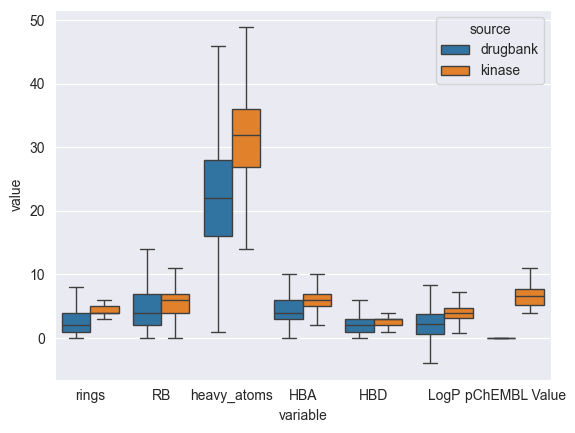

In [12]:
df_melted = df.melt(id_vars='source', value_vars=['rings', 'RB', 'heavy_atoms', 'HBA', 'HBD', 'LogP', 'pChEMBL Value'])

sns.boxplot(y='value', x='variable', hue='source',
            data=df_melted,
            showfliers=False)

<Axes: xlabel='variable', ylabel='value'>

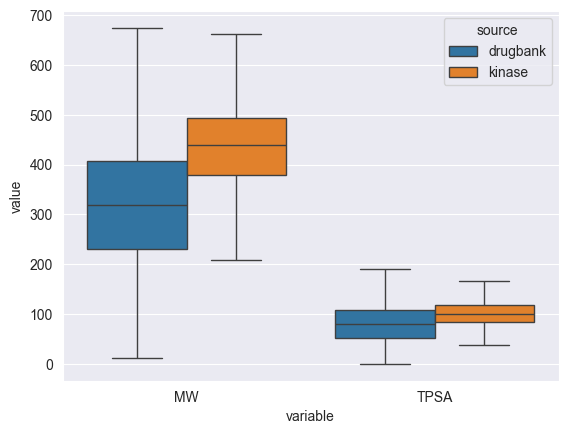

In [13]:
df_melted_2 = df.melt(id_vars='source', value_vars=['MW', 'TPSA'])

sns.boxplot(y='value', x='variable', hue='source',
            data=df_melted_2,
            showfliers=False)

In [14]:
def too_many_hbd(mol):
    # takes an RDKit mol instance, returns True if the structure is out of LRO5 bounds
    return rdMolDescriptors.CalcNumLipinskiHBD(mol) > 5

def too_many_hba(mol):
    return rdMolDescriptors.CalcNumLipinskiHBA(mol) > 10

def too_heavy(mol):
    return rdMolDescriptors.CalcExactMolWt(mol) > 500

def too_greasy(mol):
    return Crippen.MolLogP(mol) > 5

def ro5_violations(mol):
    # takes RDKit mol, return how many rules it actually violates
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    # checks the number of RO5 violations, if they are more than one, return True
    return ro5_violations(mol) > 1

def bad_greasyness_ghose(mol):
    logp = Crippen.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40

def bad_mw_ghose(mol):
    mw = rdMolDescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)

def too_rotatable_veber(mol):
    return rdMolDescriptors.CalcNumRotatableBonds(mol) > 10

def too_large_psa_veber(mol):
    return rdMolDescriptors.CalcTPSA(mol) > 140

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)

In [15]:
# Calculate properties and rule violations
df['too_many_hbd'] = df['std_rdmol'].apply(lambda mol: too_many_hbd(mol) if mol is not None else np.nan)
df['too_many_hba'] = df['std_rdmol'].apply(lambda mol: too_many_hba(mol) if mol is not None else np.nan)
df['too_heavy'] = df['std_rdmol'].apply(lambda mol: too_heavy(mol) if mol is not None else np.nan)
df['too_greasy'] = df['std_rdmol'].apply(lambda mol: too_greasy(mol) if mol is not None else np.nan)
df['violates_lipinski'] = df['std_rdmol'].apply(lambda mol: violates_lipinski(mol) if mol is not None else np.nan)

df['bad_greasyness_ghose'] = df['std_rdmol'].apply(lambda mol: bad_greasyness_ghose(mol) if mol is not None else np.nan)
df['bad_refractivity_ghose'] = df['std_rdmol'].apply(lambda mol: bad_refractivity_ghose(mol) if mol is not None else np.nan)
df['bad_mw_ghose'] = df['std_rdmol'].apply(lambda mol: bad_mw_ghose(mol) if mol is not None else np.nan)
df['bad_atomcount_ghose'] = df['std_rdmol'].apply(lambda mol: bad_atomcount_ghose(mol) if mol is not None else np.nan)
df['violates_ghose'] = df['std_rdmol'].apply(lambda mol: violates_ghose(mol) if mol is not None else np.nan)

df['too_rotatable_veber'] = df['std_rdmol'].apply(lambda mol: too_rotatable_veber(mol) if mol is not None else np.nan)
df['too_large_psa_veber'] = df['std_rdmol'].apply(lambda mol: too_large_psa_veber(mol) if mol is not None else np.nan)
df['violates_veber'] = df['std_rdmol'].apply(lambda mol: violates_veber(mol) if mol is not None else np.nan)

In [16]:
# List of rule columns
violation_columns = [
    'too_many_hbd', 'too_many_hba', 'too_heavy', 'too_greasy', 'violates_lipinski',
    'bad_greasyness_ghose', 'bad_refractivity_ghose', 'bad_mw_ghose', 'bad_atomcount_ghose', 'violates_ghose',
    'too_rotatable_veber', 'too_large_psa_veber', 'violates_veber'
]

# Melt into long format
df_melted_3 = df.melt(id_vars='source', value_vars=violation_columns,
                    var_name='Rule', value_name='Violated')

# Calculate violation rates
violation_rates = (
    df_melted_3.groupby(['Rule', 'source'])['Violated']
    .mean()
    .reset_index()
)

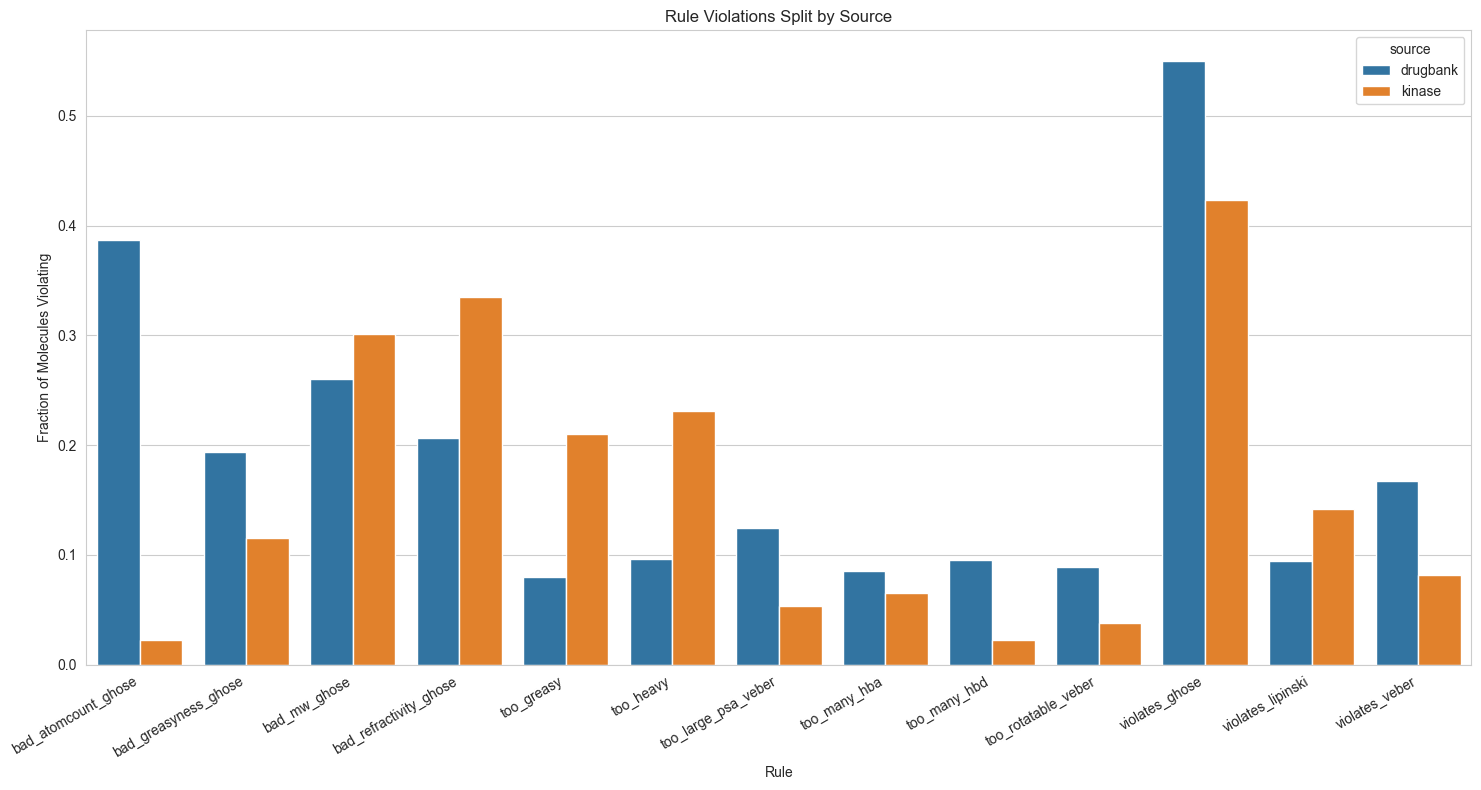

In [17]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15, 8))
    sns.barplot(data=violation_rates, x='Rule', y='Violated', hue='source')
    plt.title('Rule Violations Split by Source')
    plt.ylabel('Fraction of Molecules Violating')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

## Scaffolds

was performed to identify and categorize the core structural frameworks shared among the compounds targeting Aurora-A kinase. A scaffold, in this context, refers to the central molecular backbone after removing side chains and simplifying functional groups, typically using Murcko scaffolds. This approach helps to group structurally similar molecules and reveal dominant chemotypes in the dataset. By focusing on scaffolds, we can gain insight into which core structures are most common among active compounds, assess chemical diversity, and potentially identify promising scaffolds for future lead optimization or drug design efforts.

In [18]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import Chem

def scaffold(mol):
    if mol is None:
        return None
    Chem.rdmolops.RemoveStereochemistry(mol)
    try:
        generic = MurckoScaffold.MakeScaffoldGeneric(mol)
        scaff = MurckoScaffold.GetScaffoldForMol(generic)
        return Chem.MolToSmiles(scaff)
    except Exception:
        return None

# Apply the scaffold function to each std_rdmol
df['Scaffold_SMILES'] = df['std_rdmol'].apply(scaffold)

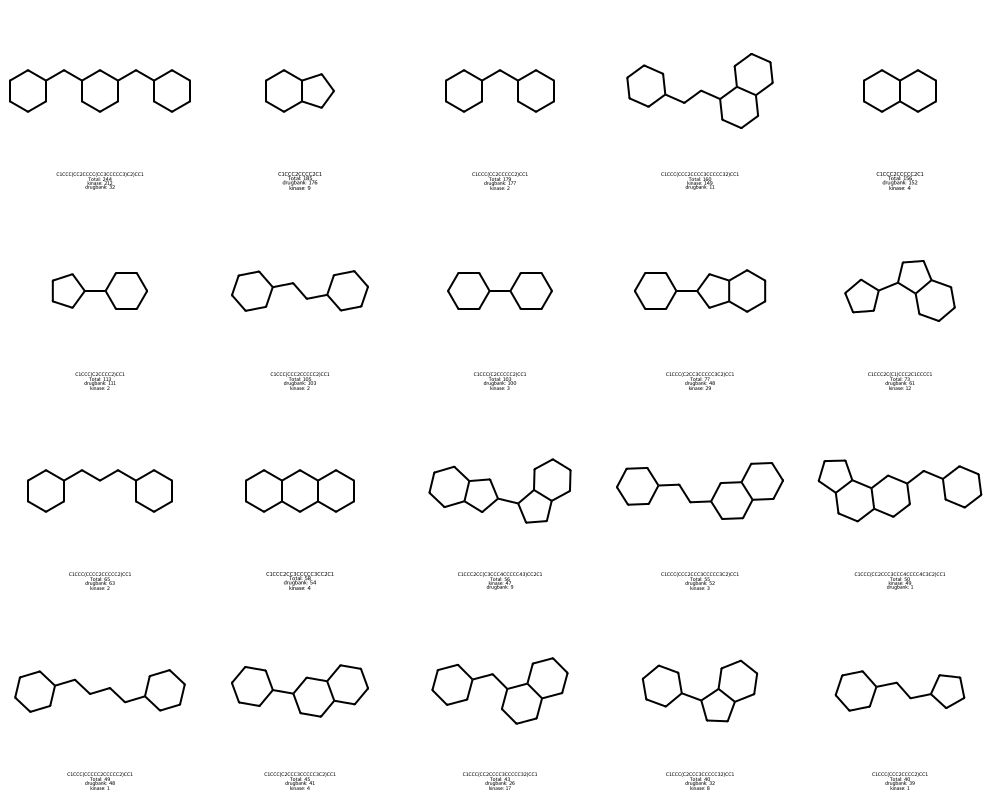

In [25]:
# Step 1: Filter valid scaffold rows
valid_df = df[df['Scaffold_SMILES'].notna() & (df['Scaffold_SMILES'] != '')]

# Step 2: Identify all sources
all_sources = set(valid_df['source'].unique())

# Step 3: Group by scaffold and collect which sources are present
scaffold_source_sets = valid_df.groupby('Scaffold_SMILES')['source'].apply(set)

# Step 4: Keep only scaffolds that have all sources
shared_scaffolds = scaffold_source_sets[scaffold_source_sets.apply(lambda s: all_sources.issubset(s))].index

# Step 5: From those, get the top 20 most frequent scaffolds
top_shared = valid_df[valid_df['Scaffold_SMILES'].isin(shared_scaffolds)]
top_scaffolds = top_shared['Scaffold_SMILES'].value_counts().head(20)

# Step 6: Convert SMILES to Mol objects
top_scaffold_smiles = top_scaffolds.index.tolist()
top_scaffold_mols = [Chem.MolFromSmiles(smi) for smi in top_scaffold_smiles]
top_scaffold_mols = [mol for mol in top_scaffold_mols if mol is not None]

# Step 7: Create legends with per-source counts
legend_texts = []
for smi in top_scaffold_smiles:
    subset = top_shared[top_shared['Scaffold_SMILES'] == smi]
    source_counts = subset['source'].value_counts()
    source_info = "\n".join([f"{src}: {cnt}" for src, cnt in source_counts.items()])
    legend = f"{smi}\nTotal: {top_scaffolds[smi]}\n{source_info}"
    legend_texts.append(legend)

# Step 8: Draw image
Chem.Draw.MolsToGridImage(top_scaffold_mols,
                           molsPerRow=5,
                           subImgSize=(200, 200),
                           legends=legend_texts)

## Chemical space and its visualization

was used to explore the structural diversity and distribution of the compounds in a lower-dimensional context. Since molecular fingerprints such as Morgan fingerprints are high-dimensional, we applied dimensionality reduction techniques like PCA (Principal Component Analysis) or t-SNE to project the data into two dimensions. This allowed us to visualize patterns, clusters, and potential outliers within the dataset. By coloring the points based on properties such as pChEMBL values or molecular origin, we were able to gain further insight into how structural features relate to bioactivity and whether certain regions of chemical space are enriched with more potent compounds.

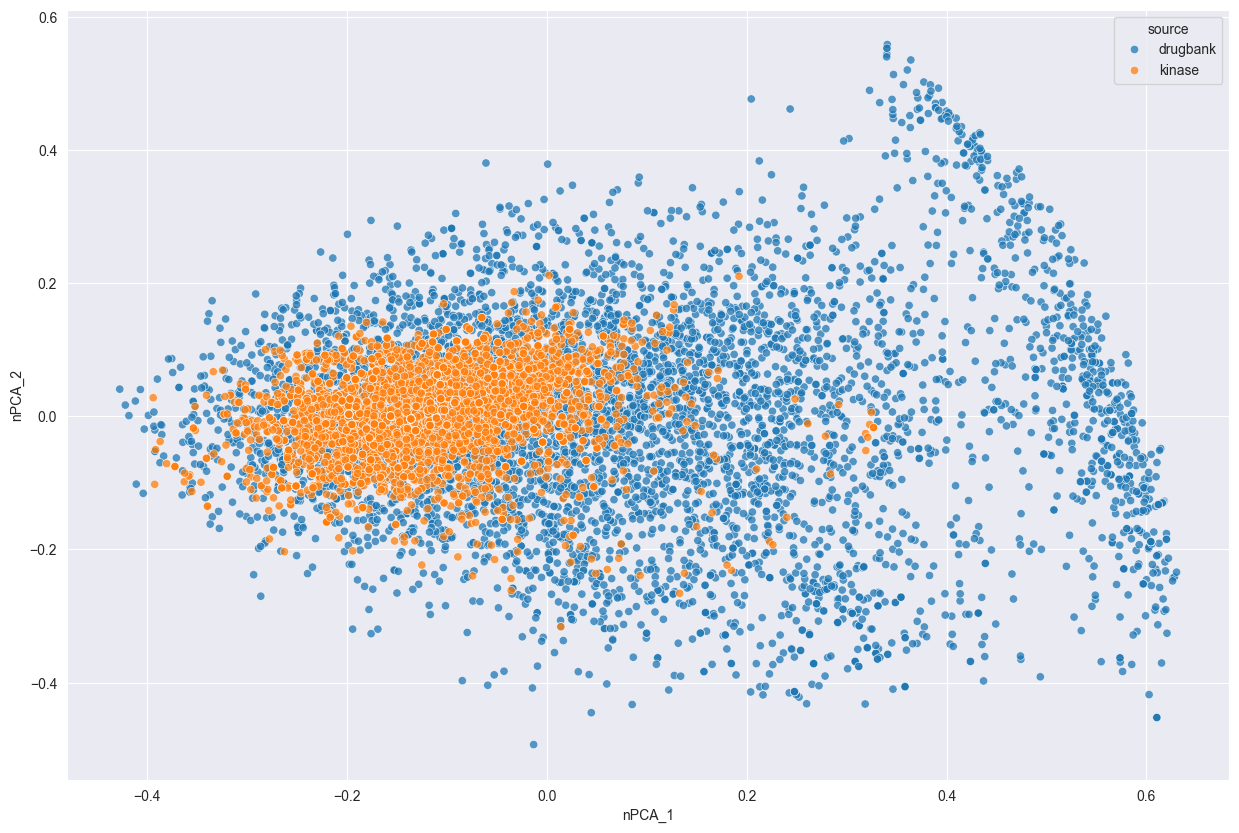

In [20]:
from matplotlib import pyplot

from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
             )

norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                      )

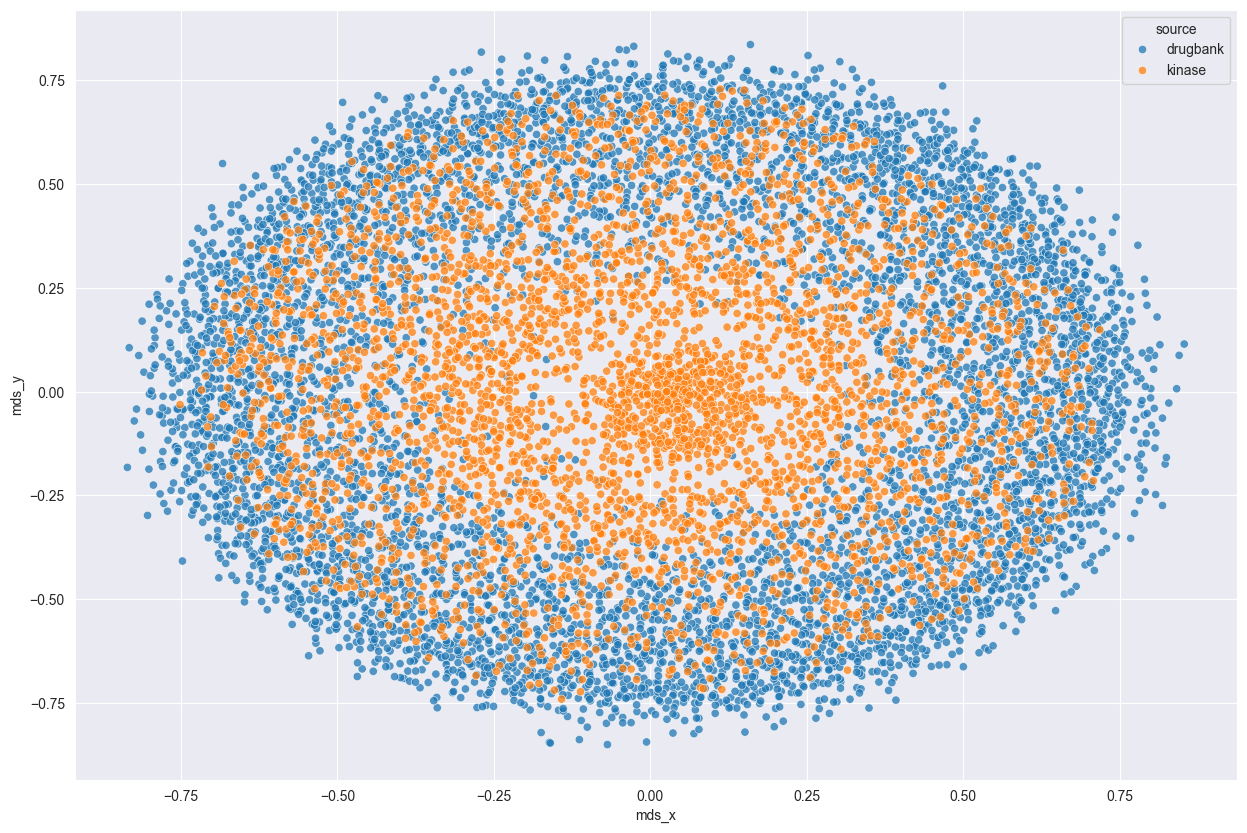

In [21]:
from scipy.spatial import distance
from sklearn import manifold

sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                      )

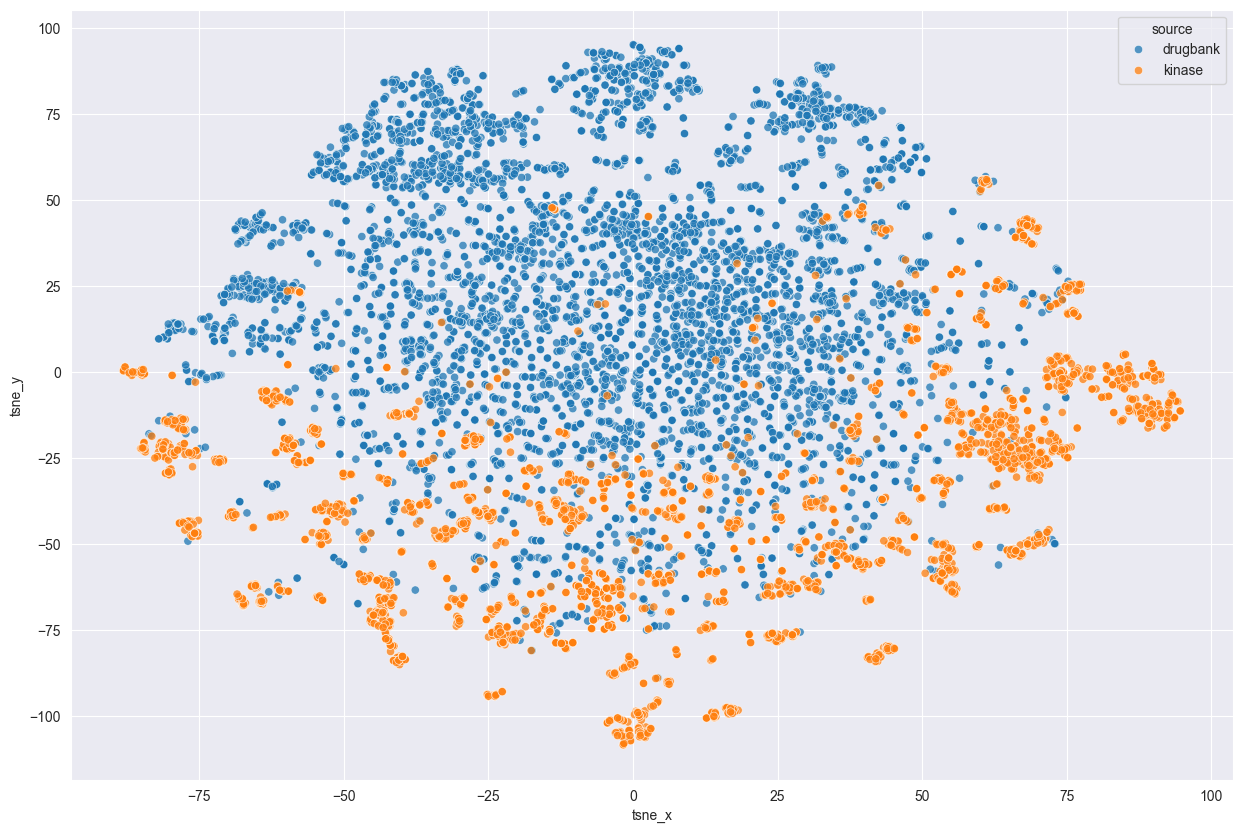

In [22]:
clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(dist_mat)

df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                      )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


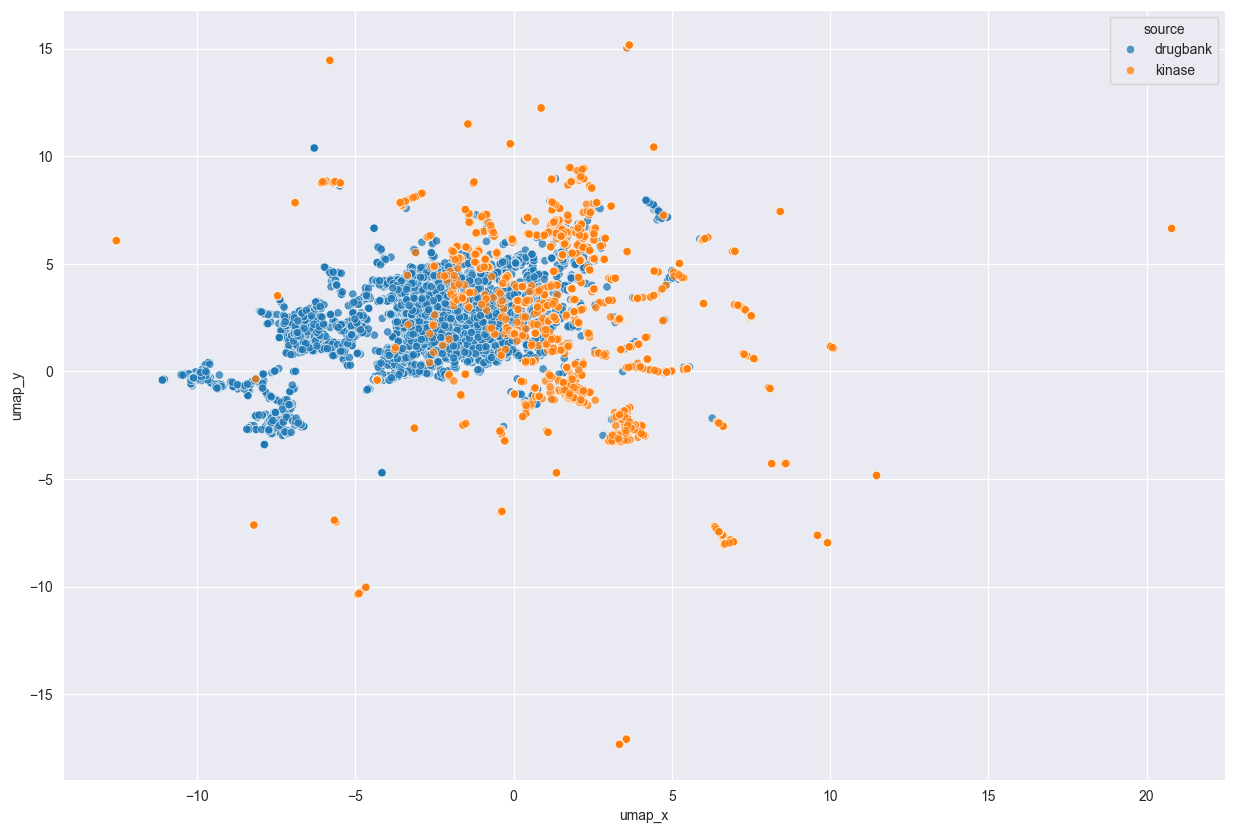

In [23]:
import umap
reducer = umap.UMAP(metric="precomputed")
embedding = reducer.fit_transform(dist_mat)

df = df.join(pd.DataFrame(embedding, columns=["umap_x", "umap_y"]))

fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="umap_x",
                      y="umap_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                      )

## Modeling

In [28]:
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

In [29]:
train_set, val_set = model_selection.train_test_split(df[df["pChEMBL Value"]>0], test_size=0.2, random_state=42)

train_set.reset_index(inplace=True)
val_set.reset_index(inplace=True)

In [30]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error kinase: {(res[res["Source"]=="kinase"]["Prediction"]-res[res["Source"]=="kinase"][predicted_value]).abs().mean()}""")
    return res

In [31]:
descriptors = [f"nPCA_{x}" for x in range(1, 43)]

from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr.fit(train_set[descriptors], train_set['pChEMBL Value'])

RandomForestRegressor(random_state=42)

In [32]:
results_rfr = get_results(model_rfr, val_set, descriptors, "pChEMBL Value")
filtered = results_rfr[results_rfr["pChEMBL Value"] > 0]

Average error whole set: 0.6452398607666616
Average error kinase: 0.6452398607666616


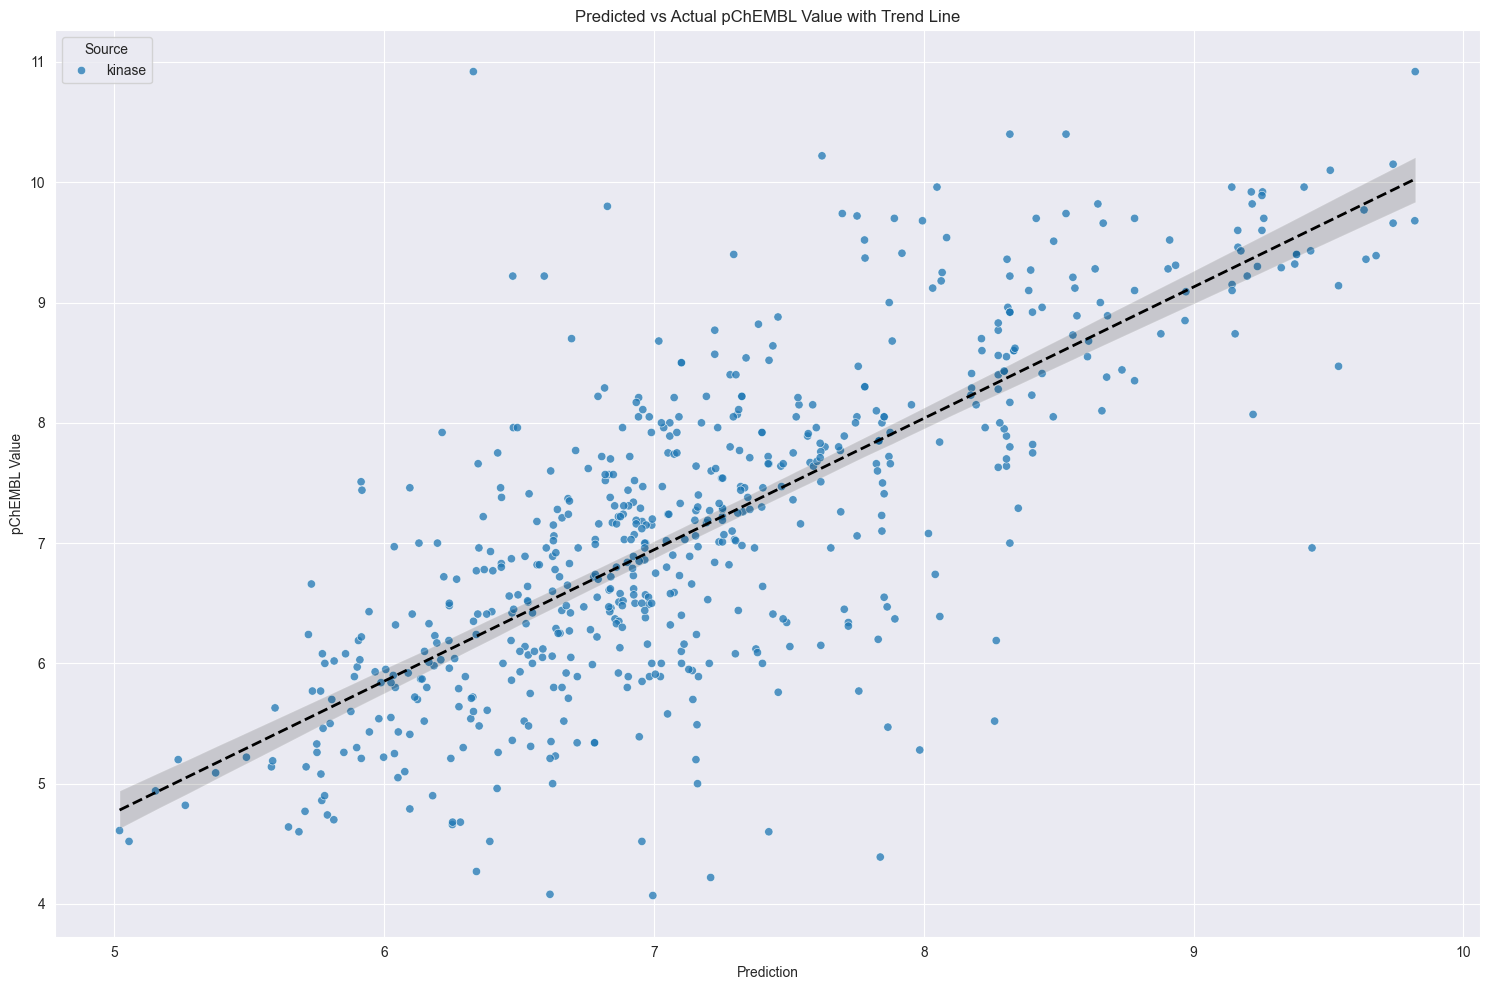

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(15, 10))

# Scatter plot with hue
sns.scatterplot(
    x="Prediction",
    y="pChEMBL Value",
    data=filtered,
    hue="Source",
    legend="brief",
    ax=ax,
    alpha=0.75
)

# Add trend line without hue for clarity
sns.regplot(
    x="Prediction",
    y="pChEMBL Value",
    data=filtered,
    scatter=False,
    ax=ax,
    color='black',  # trend line color
    line_kws={'linewidth': 2, 'linestyle': '--'}
)

ax.set_title("Predicted vs Actual pChEMBL Value with Trend Line")
plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import pearsonr

r, _ = pearsonr(results_rfr["Prediction"], results_rfr["pChEMBL Value"])
print("R (Pearson): %0.2f" % r)

print("MSE: %0.2f" % mean_squared_error(results_rfr["Prediction"], results_rfr["pChEMBL Value"]))

R (Pearson): 0.76
MSE: 0.78


In [35]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

X = df.select_dtypes(include=['number'])
Y = df['source']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

# Fill missing values with mean (or use strategy='median' or 'most_frequent')
imputer = SimpleImputer(strategy='mean')
model_rfc = make_pipeline(imputer, RandomForestClassifier(n_estimators=100, random_state=42))

model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(sum(sum(confusion_matrix(y_test, y_pred))))

1.0
[[1219    0]
 [   0  766]]
1985
